# The 1D Steady-State Advection-Diffusion Equation

## Problem description

Given is the 1D steady-state advection diffusion equation:
$$
\frac{du(x)}{dx} - \epsilon\frac{d^2 u(x)}{dx^2} = 1,~\text{where}~x\in[0, 1]
$$

with the Dirichlet boundary condition

$$
u(0) = u(1) = 0.
$$

From the given equation, the corresponding exact solution is

$$
u(x) = x - \frac{e^{- \frac{1-x}{\epsilon}} - e^{-\frac{1}{\epsilon}}}{1-e^{-\frac{1}{\epsilon}}}.
$$

## Numerical results

- Module import

In [1]:
# Import relevant modules
from math import exp

import matplotlib.pyplot as plt
import torch
from torch import Tensor

from pyapes.core.geometry import Box
from pyapes.core.mesh import Mesh
from pyapes.core.solver.fdm import FDM
from pyapes.core.solver.ops import Solver
from pyapes.core.variables import Field
from pyapes.core.variables.bcs import homogeneous_bcs


- Setup solver with the exact solution for the parametric studies

In [2]:
def sol_exact(mesh: Mesh, epsilon: float):
    """Exact solution of the given problem."""
    return mesh.X - (torch.exp(-(1 - mesh.X) / epsilon) - exp(-1 / epsilon)) / (
        1 - exp(-1 / epsilon)
    )


def advection_diffusion(epsilon: float, mesh: Mesh) -> tuple[Tensor, Tensor, Tensor]:

    # Field boundary condition: homogeneous Dirichlet with 0.0 value
    f_bc = homogeneous_bcs(1, 0.0, "dirichlet")

    # Target variable
    var = Field("U", 1, mesh, {"domain": f_bc, "obstacle": None})

    # Solve via the bicgstab method
    solver = Solver(
        {
            "fdm": {
                "method": "bicgstab",
                "tol": 1e-5,
                "max_it": 1000,
                "report": True,
            }
        }
    )
    fdm = FDM()

    solver.set_eq(fdm.grad(var) - fdm.laplacian(epsilon, var) == 1.0)
    solver.solve()

    return var(), sol_exact(mesh, epsilon), mesh.X


- Parametric study of the advection-diffusion equation (varying epsilon)

In [3]:
sols_numeric: list[Tensor] = []
sols_exact: list[Tensor] = []
epsilons: list[float] = [1, 0.5, 0.2, 0.1, 0.02]
mesh = Mesh(Box[0:1], None, [0.02])

for eps in epsilons:
    numeric, exact, x = advection_diffusion(eps, mesh)
    sols_numeric.append(numeric)
    sols_exact.append(exact)



BICGSTAB: The solution  converged after 51 iteration.
	tolerance: 3.959017816286588e-06

BICGSTAB: The solution  converged after 49 iteration.
	tolerance: 4.410003652874116e-06

BICGSTAB: The solution  converged after 50 iteration.
	tolerance: 1.4144803072199854e-07

BICGSTAB: The solution  converged after 54 iteration.
	tolerance: 7.177132189433178e-06

BICGSTAB: The solution  converged after 52 iteration.
	tolerance: 2.916204317128988e-06


- Results

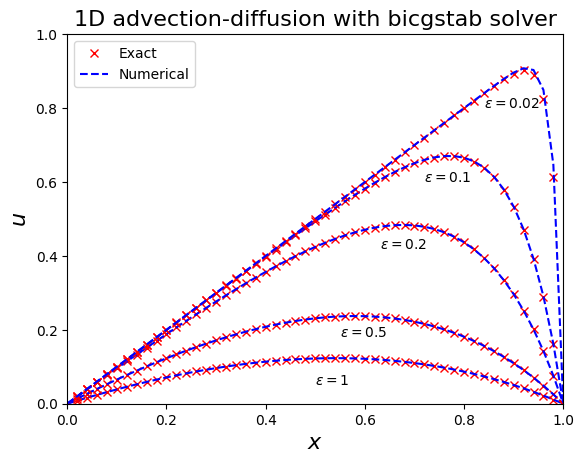

In [4]:
_, ax = plt.subplots()

for idx, (n, e) in enumerate(zip(sols_numeric, sols_exact)):
    ax.plot(
        mesh.X,
        e,
        label="Exact" if idx == 0 else None,
        marker="x",
        linestyle="None",
        color="r",
    )
    ax.plot(
        mesh.X,
        n[0],
        label="Numerical" if idx == 0 else None,
        color="b",
        linestyle="--",
    )

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax.text(0.5, 0.05, r"$\epsilon = 1$", fontsize=10)
ax.text(0.55, 0.18, r"$\epsilon = 0.5$", fontsize=10)
ax.text(0.63, 0.42, r"$\epsilon = 0.2$", fontsize=10)
ax.text(0.72, 0.6, r"$\epsilon = 0.1$", fontsize=10)
ax.text(0.84, 0.8, r"$\epsilon = 0.02$", fontsize=10)

ax.set_xlabel(r"$x$", fontsize=16)
ax.set_ylabel(r"$u$", fontsize=16)

ax.set_title(
    "1D advection-diffusion with bicgstab solver",
    fontsize=16,
)
ax.legend(loc="upper left")
